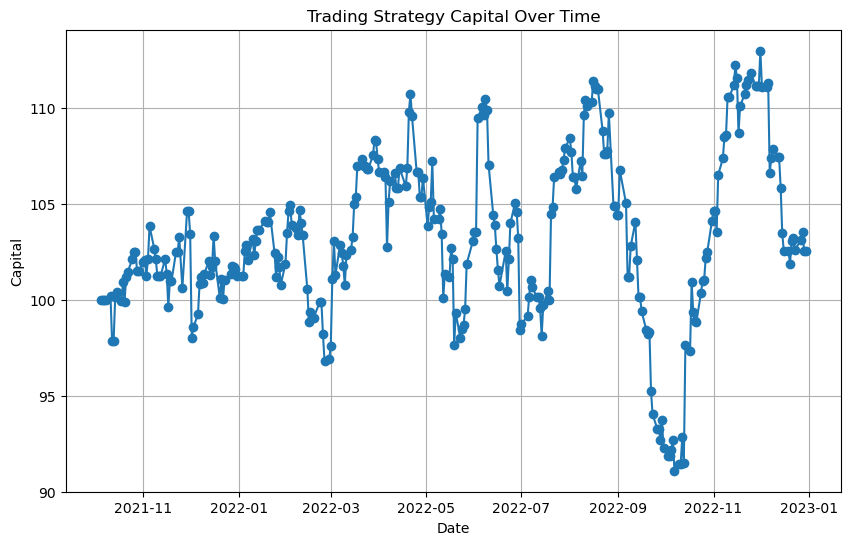

          Date     Capital
0   2021-10-05  100.000000
1   2021-10-06  100.000000
2   2021-10-07  100.000000
3   2021-10-08  100.000000
4   2021-10-11  100.209925
..         ...         ...
308 2022-12-23  102.622353
309 2022-12-27  103.104526
310 2022-12-28  103.560952
311 2022-12-29  102.541021
312 2022-12-30  102.541021

[313 rows x 2 columns]


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def simulate_strategy(filepath, initial_capital=100):
    # 读取 Excel 并确保日期列为 datetime
    df = pd.read_excel(filepath)
    df['Names Date'] = pd.to_datetime(df['Names Date'])

    # 构造以 “日期 × PERMNO” 为索引的开盘价和预测值表
    df_open = df.pivot(index='Names Date', columns='PERMNO', values='Open Price')
    df_pred = df.pivot(index='Names Date', columns='PERMNO', values='Predicted_Class')

    # 按日期升序排列
    dates = sorted(df_open.index.unique())
    principal = initial_capital
    history = []

    # 从第一个有预测的日期 (dates[1]) 开始：
    # 取 dates[k+1] 的 Predicted_Class==1，按 dates[k+1] 开盘价买入，
    # 次日（dates[k+2]）开盘全部卖出
    for k in range(len(dates) - 2):
        date_pred = dates[k + 1]
        date_buy = date_pred
        date_sell = dates[k + 2]

        # 若某天缺失预测或开盘价，则跳过，本金保持不变
        if (date_pred not in df_pred.index
                or date_buy not in df_open.index
                or date_sell not in df_open.index):
            history.append((date_sell, principal))
            continue

        # 找出当天 (date_pred) 预测为 1 的所有 PERMNO
        pred_row = df_pred.loc[date_pred]
        tickers = pred_row[pred_row == 1].index.tolist()

        # 过滤出在买入日和卖出日都存在开盘价的股票
        valid_tickers = [
            t for t in tickers
            if pd.notna(df_open.at[date_buy, t])
            and pd.notna(df_open.at[date_sell, t])
        ]
        m = len(valid_tickers)
        if m == 0:
            # 如果没有可买入股票，则本金保持不变
            history.append((date_sell, principal))
            continue

        # 本金均分到每只股票
        amount_per = principal / m
        new_principal = 0.0

        for t in valid_tickers:
            open_buy = df_open.at[date_buy, t]
            open_sell = df_open.at[date_sell, t]
            shares = amount_per / open_buy
            new_principal += shares * open_sell

        principal = new_principal
        history.append((date_sell, principal))

    hist_df = pd.DataFrame(history, columns=['Date', 'Capital'])
    return hist_df

# ———— 使用范例 ————
# 请把下面路径替换成你的 Excel 文件路径
filepath = 'GraphAutoencoderoutput_Test_data_with_predictions.xlsx'
hist_df = simulate_strategy(filepath)

# 绘制资金随时间变化的曲线
plt.figure(figsize=(10, 6))
plt.plot(hist_df['Date'], hist_df['Capital'], marker='o')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.title('Trading Strategy Capital Over Time')
plt.grid(True)
plt.show()

# 如果想查看每个卖出日对应的资金数，可打印 hist_df
print(hist_df)


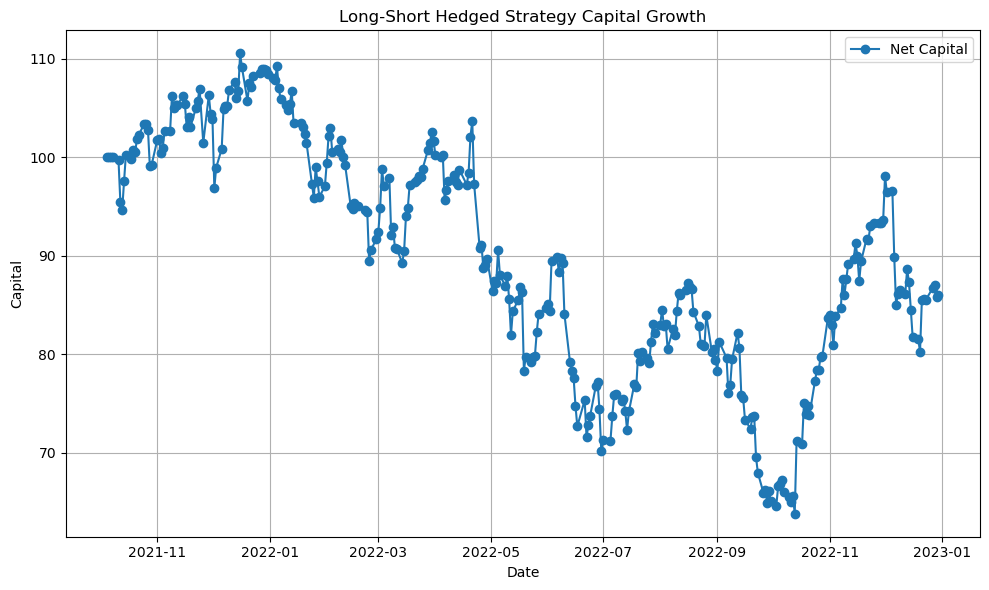

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def long_short_strategy(filepath, initial_capital=100):
    df = pd.read_excel(filepath)
    df['Names Date'] = pd.to_datetime(df['Names Date'])

    df_open = df.pivot(index='Names Date', columns='PERMNO', values='Open Price')
    df_pred = df.pivot(index='Names Date', columns='PERMNO', values='Predicted_Class')

    dates = sorted(df_open.index.unique())
    capital = initial_capital
    capital_history = []

    for t in range(len(dates) - 2):
        date_t = dates[t]
        date_buy = dates[t + 1]
        date_sell = dates[t + 2]

        if date_buy not in df_pred.index or date_buy not in df_open.index or date_sell not in df_open.index:
            capital_history.append((date_sell, capital))
            continue

        pred_row = df_pred.loc[date_buy]
        open_buy = df_open.loc[date_buy]
        open_sell = df_open.loc[date_sell]

        # 多头篮子
        long_tickers = pred_row[pred_row == 1].index.tolist()
        # 空头篮子（我们设为 Predicted_Class == -1）
        short_tickers = pred_row[pred_row == -1].index.tolist()

        long_returns = []
        short_returns = []

        for ticker in long_tickers:
            try:
                p_buy = open_buy[ticker]
                p_sell = open_sell[ticker]
                if pd.notna(p_buy) and pd.notna(p_sell) and p_buy > 0:
                    long_returns.append((p_sell - p_buy) / p_buy)
            except:
                continue

        for ticker in short_tickers:
            try:
                p_sell = open_buy[ticker]  # 做空卖出
                p_buy = open_sell[ticker]  # 买入平仓
                if pd.notna(p_buy) and pd.notna(p_sell) and p_sell > 0:
                    short_returns.append((p_sell - p_buy) / p_sell)  # 注意反向
            except:
                continue

        if not long_returns and not short_returns:
            capital_history.append((date_sell, capital))
            continue

        long_avg = np.mean(long_returns) if long_returns else 0
        short_avg = np.mean(short_returns) if short_returns else 0

        net_return = long_avg - short_avg
        capital *= (1 + net_return)
        capital_history.append((date_sell, capital))

    hist_df = pd.DataFrame(capital_history, columns=['Date', 'Capital'])
    return hist_df

# 使用方法
filepath = 'GraphAutoencoderoutput_Test_data_with_predictions.xlsx'
result_df = long_short_strategy(filepath)

# 可视化
plt.figure(figsize=(10, 6))
plt.plot(result_df['Date'], result_df['Capital'], label='Net Capital', marker='o')
plt.title('Long-Short Hedged Strategy Capital Growth')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


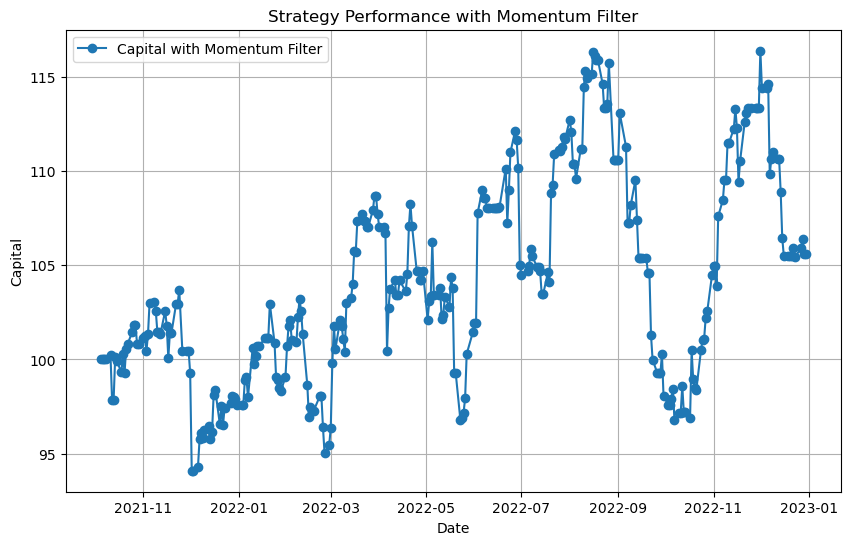

          Date     Capital
0   2021-10-05  100.000000
1   2021-10-06  100.000000
2   2021-10-07  100.000000
3   2021-10-08  100.000000
4   2021-10-11  100.209925
..         ...         ...
308 2022-12-23  105.411867
309 2022-12-27  105.907147
310 2022-12-28  106.375980
311 2022-12-29  105.588821
312 2022-12-30  105.588821

[313 rows x 2 columns]


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def simulate_strategy_with_momentum(filepath, initial_capital=100, momentum_window=3):
    df = pd.read_excel(filepath)
    df['Names Date'] = pd.to_datetime(df['Names Date'])

    df_open = df.pivot(index='Names Date', columns='PERMNO', values='Open Price')
    df_pred = df.pivot(index='Names Date', columns='PERMNO', values='Predicted_Class')

    dates = sorted(df_open.index.unique())
    principal = initial_capital
    history = []

    for k in range(len(dates) - 2):
        date_pred = dates[k + 1]
        date_buy = date_pred
        date_sell = dates[k + 2]

        if (date_pred not in df_pred.index
                or date_buy not in df_open.index
                or date_sell not in df_open.index):
            history.append((date_sell, principal))
            continue

        pred_row = df_pred.loc[date_pred]
        tickers_predicted_up = pred_row[pred_row == 1].index.tolist()

        # --- 动量过滤逻辑 ---
        valid_tickers = []
        for ticker in tickers_predicted_up:
            try:
                price_now = df_open.at[date_buy, ticker]
                price_past = df_open.at[dates[k + 1 - momentum_window], ticker]
                if pd.notna(price_now) and pd.notna(price_past) and price_past > 0:
                    momentum = (price_now - price_past) / price_past
                    if momentum > 0:
                        # 同时确保买入和卖出日有价格
                        if pd.notna(df_open.at[date_sell, ticker]):
                            valid_tickers.append(ticker)
            except:
                continue

        m = len(valid_tickers)
        if m == 0:
            history.append((date_sell, principal))
            continue

        amount_per = principal / m
        new_principal = 0.0

        for t in valid_tickers:
            open_buy = df_open.at[date_buy, t]
            open_sell = df_open.at[date_sell, t]
            shares = amount_per / open_buy
            new_principal += shares * open_sell

        principal = new_principal
        history.append((date_sell, principal))

    hist_df = pd.DataFrame(history, columns=['Date', 'Capital'])
    return hist_df

# 使用方法
filepath = 'GraphAutoencoderoutput_Test_data_with_predictions.xlsx'
hist_df = simulate_strategy_with_momentum(filepath, momentum_window=3)

# 绘图展示资金变化
plt.figure(figsize=(10, 6))
plt.plot(hist_df['Date'], hist_df['Capital'], marker='o', label='Capital with Momentum Filter')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.title('Strategy Performance with Momentum Filter')
plt.grid(True)
plt.legend()
plt.show()

print(hist_df)


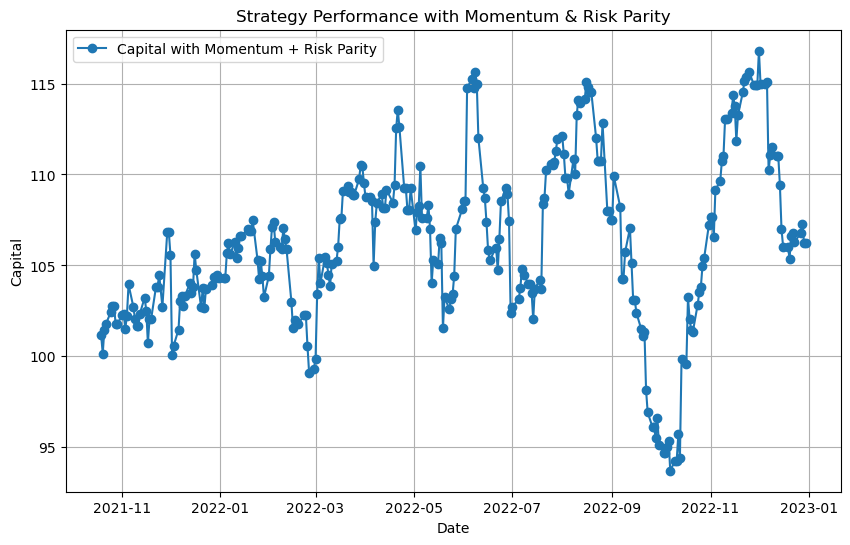

          Date     Capital
0   2021-10-19  101.172100
1   2021-10-20  100.153509
2   2021-10-21  101.470250
3   2021-10-22  101.785540
4   2021-10-25  102.437204
..         ...         ...
298 2022-12-23  106.282073
299 2022-12-27  106.781441
300 2022-12-28  107.257155
301 2022-12-29  106.219110
302 2022-12-30  106.219110

[303 rows x 2 columns]


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def simulate_strategy_with_momentum_and_risk_parity(filepath, initial_capital=100, momentum_window=3, vol_window=10, top_n_momentum=30):
    df = pd.read_excel(filepath)
    df['Names Date'] = pd.to_datetime(df['Names Date'])

    df_open = df.pivot(index='Names Date', columns='PERMNO', values='Open Price')
    df_pred = df.pivot(index='Names Date', columns='PERMNO', values='Predicted_Class')

    dates = sorted(df_open.index.unique())
    principal = initial_capital
    history = []

    for k in range(vol_window, len(dates) - 2):
        date_pred = dates[k + 1]
        date_buy = date_pred
        date_sell = dates[k + 2]

        if (date_pred not in df_pred.index
                or date_buy not in df_open.index
                or date_sell not in df_open.index):
            history.append((date_sell, principal))
            continue

        # --------------------
        # Step 1: 计算过去10日超额收益率做动量轮动
        # --------------------
        past_returns = (df_open.loc[dates[k - momentum_window + 1]:dates[k]] / df_open.loc[dates[k - momentum_window]] - 1)
        mean_returns = past_returns.mean()
        overall_mean = mean_returns.mean()
        excess_returns = mean_returns - overall_mean
        top_momentum_stocks = excess_returns.nlargest(top_n_momentum).index.tolist()

        # --------------------
        # Step 2: 从 Predicted_Class==1 中筛选领涨股
        # --------------------
        pred_row = df_pred.loc[date_pred]
        tickers_predicted_up = pred_row[pred_row == 1].index.tolist()

        selected_tickers = list(set(top_momentum_stocks).intersection(tickers_predicted_up))

        if len(selected_tickers) == 0:
            history.append((date_sell, principal))
            continue

        # --------------------
        # Step 3: 计算波动率（标准差）用于风险平价
        # --------------------
        volatility_dict = {}
        for ticker in selected_tickers:
            try:
                prices = df_open.loc[dates[k - vol_window + 1]:dates[k], ticker]
                vol = prices.pct_change().std()
                if np.isnan(vol) or vol == 0:
                    continue
                volatility_dict[ticker] = vol
            except:
                continue

        if len(volatility_dict) == 0:
            history.append((date_sell, principal))
            continue

        # --------------------
        # Step 4: 风险平价权重计算（1/vol 再归一化）
        # --------------------
        inv_vol = {t: 1 / v for t, v in volatility_dict.items()}
        total_inv_vol = sum(inv_vol.values())
        weights = {t: inv_vol[t] / total_inv_vol for t in inv_vol}

        # --------------------
        # Step 5: 按权重建仓 & 模拟持仓
        # --------------------
        new_principal = 0.0
        for t in weights:
            try:
                open_buy = df_open.at[date_buy, t]
                open_sell = df_open.at[date_sell, t]
                if pd.isna(open_buy) or pd.isna(open_sell):
                    continue
                alloc_cash = principal * weights[t]
                shares = alloc_cash / open_buy
                new_principal += shares * open_sell
            except:
                continue

        principal = new_principal
        history.append((date_sell, principal))

    hist_df = pd.DataFrame(history, columns=['Date', 'Capital'])
    return hist_df

# 使用方法
filepath = 'GraphAutoencoderoutput_Test_data_with_predictions.xlsx'
hist_df = simulate_strategy_with_momentum_and_risk_parity(filepath, momentum_window=3, vol_window=10, top_n_momentum=30)

# 绘图展示资金变化
plt.figure(figsize=(10, 6))
plt.plot(hist_df['Date'], hist_df['Capital'], marker='o', label='Capital with Momentum + Risk Parity')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.title('Strategy Performance with Momentum & Risk Parity')
plt.grid(True)
plt.legend()
plt.show()

print(hist_df)


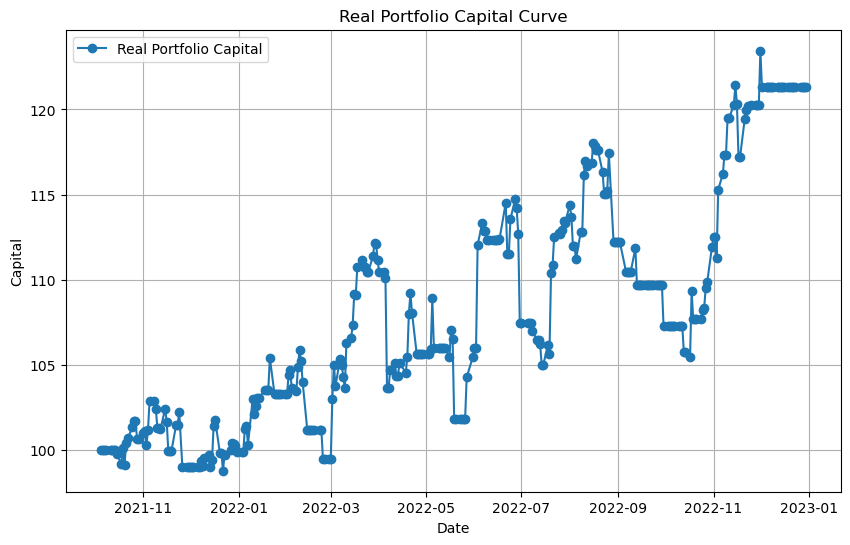

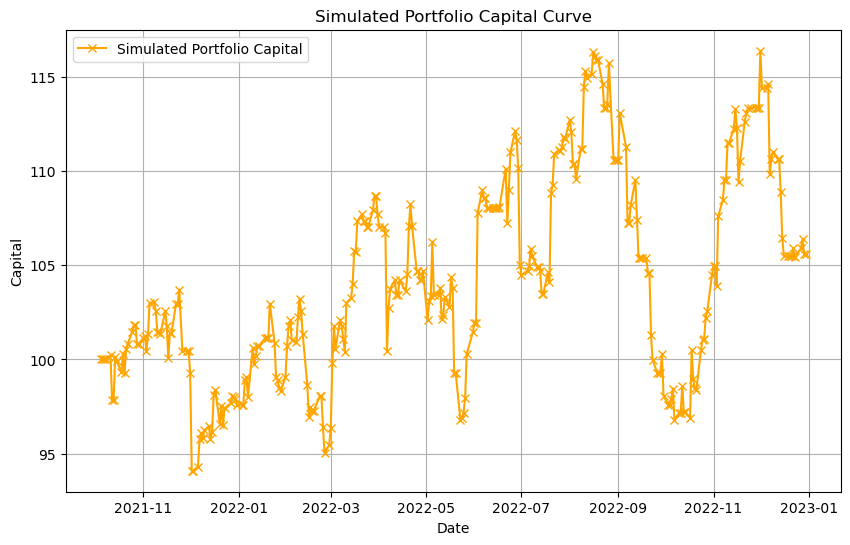

          Date  Sim_Capital  Real_Capital
0   2021-10-05   100.000000     100.00000
1   2021-10-06   100.000000     100.00000
2   2021-10-07   100.000000     100.00000
3   2021-10-08   100.000000     100.00000
4   2021-10-11   100.209925     100.00000
..         ...          ...           ...
308 2022-12-23   105.411867     121.33136
309 2022-12-27   105.907147     121.33136
310 2022-12-28   106.375980     121.33136
311 2022-12-29   105.588821     121.33136
312 2022-12-30   105.588821     121.33136

[313 rows x 3 columns]


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def simulate_with_real_and_sim(filepath, initial_capital=100, momentum_window=3, drawdown_threshold=0.015, signal_threshold=0.008):
    """
    生成两个持仓：模拟仓 (sim) 和真实仓 (real)。
    - 模拟仓：按照动量筛选逻辑正常交易。
    - 真实仓：初始冻结；当模拟仓某一期单日收益超过 signal_threshold 时，在下一期解冻并开始跟随交易；
      如果真实仓某一期单日回撤超过 drawdown_threshold，则该期交易后冻结，等待下一次信号解冻。
    最后返回包含每个 sell 日的日期、模拟仓和真实仓资金的 DataFrame。
    """
    # 读取数据
    df = pd.read_excel(filepath)
    df['Names Date'] = pd.to_datetime(df['Names Date'])
    
    # 构造开盘价和预测分类的透视表
    df_open = df.pivot(index='Names Date', columns='PERMNO', values='Open Price')
    df_pred = df.pivot(index='Names Date', columns='PERMNO', values='Predicted_Class')
    
    # 按日期排序
    dates = sorted(df_open.index.unique())
    
    # 初始化
    sim_cap = initial_capital       # 模拟仓资金
    real_cap = initial_capital      # 真实仓资金
    real_active = False             # 真实仓当前是否解冻可以交易
    activation_flag = False         # 标记下期是否解冻真是仓
    history = []                    # 存储 (sell_date, sim_cap, real_cap)
    
    # 遍历所有可交易期 (需保证有 k+1 和 k+2)
    for k in range(len(dates) - 2):
        date_pred = dates[k + 1]   # 预测时点，也是买入日
        date_buy = date_pred
        date_sell = dates[k + 2]
        
        prev_sim = sim_cap
        prev_real = real_cap
        
        # 如果上期收到了信号，本期开始交易真实仓
        if activation_flag:
            real_active = True
            activation_flag = False
        
        # 检查所需日期是否在数据中
        if (date_pred not in df_pred.index) or (date_buy not in df_open.index) or (date_sell not in df_open.index):
            # 无法交易：资金保持不变
            history.append((date_sell, sim_cap, real_cap))
            continue
        
        # 取出预测向上标记的股票列表
        pred_row = df_pred.loc[date_pred]
        tickers_predicted_up = pred_row[pred_row == 1].index.tolist()
        
        # 动量过滤：过去 momentum_window 个周期到现在必须涨幅正
        valid_tickers = []
        for ticker in tickers_predicted_up:
            try:
                # 当前买入日开盘价
                price_now = df_open.at[date_buy, ticker]
                # momentum_window 之前的开盘价
                date_past_index = k + 1 - momentum_window
                if date_past_index < 0:
                    # 如果不够窗口长度，则无法计算动量，跳过
                    continue
                date_past = dates[date_past_index]
                price_past = df_open.at[date_past, ticker]
                # 确保价格可用且过去价格 > 0
                if pd.notna(price_now) and pd.notna(price_past) and price_past > 0:
                    momentum = (price_now - price_past) / price_past
                    if momentum > 0:
                        # 同时确认卖出日有价格
                        if pd.notna(df_open.at[date_sell, ticker]):
                            valid_tickers.append(ticker)
            except KeyError:
                # 某些日期/股票数据缺失
                continue
        
        m = len(valid_tickers)
        
        # —— 模拟仓交易逻辑 —— #
        if m == 0:
            # 没有可交易股票，模拟仓资金保持不变
            new_sim = sim_cap
        else:
            amount_per_sim = sim_cap / m
            new_sim = 0.0
            for t in valid_tickers:
                open_buy = df_open.at[date_buy, t]
                open_sell = df_open.at[date_sell, t]
                shares = amount_per_sim / open_buy
                new_sim += shares * open_sell
        
        # 计算模拟仓当期收益率
        sim_return = (new_sim - prev_sim) / prev_sim if prev_sim > 0 else 0.0
        
        # 如果模拟仓当期收益超过信号阈值，则在下一期解冻真实仓
        if sim_return > signal_threshold:
            activation_flag = True
        
        sim_cap = new_sim
        
        # —— 真实仓交易逻辑 —— #
        if real_active:
            if m == 0:
                # 没有可交易股票，资金保持不变
                new_real = real_cap
                real_return = 0.0
            else:
                amount_per_real = real_cap / m
                new_real = 0.0
                for t in valid_tickers:
                    open_buy = df_open.at[date_buy, t]
                    open_sell = df_open.at[date_sell, t]
                    shares = amount_per_real / open_buy
                    new_real += shares * open_sell
                # 计算真实仓当期收益率（回撤为负）
                real_return = (new_real - prev_real) / prev_real if prev_real > 0 else 0.0
                
                # 如果当期回撤超过 drawdown_threshold，则交易完成后冻结真实仓
                if real_return < -drawdown_threshold:
                    real_active = False
            real_cap = new_real
        else:
            # 冻结状态下，资金不变
            real_cap = prev_real
        
        # 记录当期（sell 日）资金情况
        history.append((date_sell, sim_cap, real_cap))
    
    # 构造 DataFrame
    hist_df = pd.DataFrame(history, columns=['Date', 'Sim_Capital', 'Real_Capital'])
    return hist_df

# 使用示例
filepath = 'GraphAutoencoderoutput_Test_data_with_predictions.xlsx'
hist_df = simulate_with_real_and_sim(filepath, initial_capital=100, momentum_window=3)

# 可视化真实仓资金曲线
plt.figure(figsize=(10, 6))
plt.plot(hist_df['Date'], hist_df['Real_Capital'], marker='o', label='Real Portfolio Capital')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.title('Real Portfolio Capital Curve')
plt.grid(True)
plt.legend()
plt.show()

# 如果需要，也可以同时可视化模拟仓
plt.figure(figsize=(10, 6))
plt.plot(hist_df['Date'], hist_df['Sim_Capital'], marker='x', color='orange', label='Simulated Portfolio Capital')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.title('Simulated Portfolio Capital Curve')
plt.grid(True)
plt.legend()
plt.show()

print(hist_df)
